## 事前環境構築

```
$ sudo apt-get install -y python3
$ python3 -m venv ~/.venv
$ source ~/.venv/bin/activate
$ pip install jupyter tensorboard jupyter-tensorboard
$ jupyter notebook
```

In [ ]:
#環境構築 (jupyterは事前に実行)
# for keras-rl
!sudo apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb libav-tools xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install gym keras-rl

# tensorboard
# !pip install tensorflow tensorboard jupyter jupyter-tensorboard

# モデル可視化
!sudo apt-get -y install graphviz
!pip install pydot graphviz
# 学習曲線可視化
!pip install bokeh pandas

In [3]:
#環境設定
import numpy as np
import random

SEED=123
random.seed(SEED)
np.random.seed(SEED)

# OpenAI gym problem setting
#ENV_NAME = 'CartPole-v0'
ENV_NAME = 'MsPacman-v0'

# Atrariゲームは画面を直接入力にする
INPUT_SHAPE = (128, 128)
WINDOW_LENGTH = 4

# 学習曲線保存ファイル
HIST_FILE = 'dqn_{}_history.csv'.format(ENV_NAME)
# モデルファイル
MODEL_FILE = 'dqn_model_{}.json'.format(ENV_NAME)
# 訓練済み評価値最大モデルパラメータファイル
BEST_WEIGHT_FILE = 'dqn_{}_best_weights.h5f'.format(ENV_NAME)
# 最後のモデルパラメータファイル
LAST_MODEL_FILE = 'dqn_{}_last_model.h5f'.format(ENV_NAME)
# メモリファイル (学習が進むと数GB)
MEMORY_FILE = '/media/sf_share/dqn_{}_memory.pkl'.format(ENV_NAME)

In [4]:
#初期設定
import gym
from PIL import Image

from bokeh.io import push_notebook

from copy import deepcopy

import numpy as np

from keras.callbacks import History, Callback, ModelCheckpoint, CSVLogger
from keras.optimizers import Adam
from keras.models import load_model

from rl.agents.dqn import DQNAgent
from rl.callbacks import TestLogger, TrainEpisodeLogger, TrainIntervalLogger, Visualizer, CallbackList
from rl.core import Processor
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

env = gym.make(ENV_NAME)
env.seed(SEED)
nb_actions = env.action_space.n

ACTIONS = env.unwrapped.get_action_meanings()
ACTION_MAP = {0:ACTIONS.index("UP"), 1:ACTIONS.index("RIGHT"),
              2:ACTIONS.index("LEFT"), 3:ACTIONS.index("DOWN")}
print(nb_actions, ACTIONS)

"""
Atari(Game) Processor
"""
class AtariProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')  # resize and convert to grayscale
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')  # saves storage in experience memory

    def process_state_batch(self, batch):
        # We could perform this processing step in `process_observation`. In this case, however,
        # we would need to store a `float32` array instead, which is 4x more memory intensive than
        # an `uint8` array. This matters if we store 1M observations.
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_action(self, action):
        return ACTION_MAP[action]
    
    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

    
"""
Keras Callback Stream Graph Updater
"""
class GraphUpdater(Callback):

    """
    @param target bokeh.io.show return object
    @param source bokeh.plotting.ColumnDataSource
    @param df pandas.DataFrame
    """
    def __init__(self, target, source, df):
        self.target = target
        self.source = source
        self.lastIndex = len(df.index)
    
    def on_epoch_end(self, epoch, logs={}):
        self.source.stream({'index':[self.lastIndex], 'epoch':[epoch], 'episode_reward':[logs.get('episode_reward')], 
                            'nb_episode_steps':[logs.get('nb_episode_steps')], 'nb_steps':[logs.get('nb_steps')]})
        self.lastIndex += 1
        push_notebook(handle=self.target)

        
"""
comment out step initialize
"""
class ResumableDQNAgent(DQNAgent):
    def save(self, filepath, overwrite=False):
        # 学習率も合わせて保管
        self.model.save(filepath, overwrite=overwrite)
        
    def load(self, filepath):
        self.model = load_model(filepath)
        self.target_model = load_model(filepath)
    
    def fit(self, env, nb_steps, action_repetition=1, callbacks=None, verbose=1,
            visualize=False, nb_max_start_steps=0, start_step_policy=None, log_interval=10000,
            nb_max_episode_steps=None):
        if not self.compiled:
            raise RuntimeError('Your tried to fit your agent but it hasn\'t been compiled yet. Please call `compile()` before `fit()`.')
        if action_repetition < 1:
            raise ValueError('action_repetition must be >= 1, is {}'.format(action_repetition))

        self.training = True

        callbacks = [] if not callbacks else callbacks[:]

        if verbose == 1:
            callbacks += [TrainIntervalLogger(interval=log_interval)]
        elif verbose > 1:
            callbacks += [TrainEpisodeLogger()]
        if visualize:
            callbacks += [Visualizer()]
        history = History()
        callbacks += [history]
        callbacks = CallbackList(callbacks)
        if hasattr(callbacks, 'set_model'):
            callbacks.set_model(self)
        else:
            callbacks._set_model(self)
        callbacks._set_env(env)
        params = {
            'nb_steps': nb_steps,
        }
        if hasattr(callbacks, 'set_params'):
            callbacks.set_params(params)
        else:
            callbacks._set_params(params)
        self._on_train_begin()
        callbacks.on_train_begin()

        episode = 0
        """ comment out step initialize
        # self.step = 0 
        """
        observation = None
        episode_reward = None
        episode_step = None
        did_abort = False
        try:
            while self.step < nb_steps:
                if observation is None:  # start of a new episode
                    callbacks.on_episode_begin(episode)
                    episode_step = 0
                    episode_reward = 0.

                    # Obtain the initial observation by resetting the environment.
                    self.reset_states()
                    observation = deepcopy(env.reset())
                    if self.processor is not None:
                        observation = self.processor.process_observation(observation)
                    assert observation is not None

                    # Perform random starts at beginning of episode and do not record them into the experience.
                    # This slightly changes the start position between games.
                    nb_random_start_steps = 0 if nb_max_start_steps == 0 else np.random.randint(nb_max_start_steps)
                    for _ in range(nb_random_start_steps):
                        if start_step_policy is None:
                            action = env.action_space.sample()
                        else:
                            action = start_step_policy(observation)
                        if self.processor is not None:
                            action = self.processor.process_action(action)
                        callbacks.on_action_begin(action)
                        observation, reward, done, info = env.step(action)
                        observation = deepcopy(observation)
                        if self.processor is not None:
                            observation, reward, done, info = self.processor.process_step(observation, reward, done, info)
                        callbacks.on_action_end(action)
                        if done:
                            warnings.warn('Env ended before {} random steps could be performed at the start. You should probably lower the `nb_max_start_steps` parameter.'.format(nb_random_start_steps))
                            observation = deepcopy(env.reset())
                            if self.processor is not None:
                                observation = self.processor.process_observation(observation)
                            break

                # At this point, we expect to be fully initialized.
                assert episode_reward is not None
                assert episode_step is not None
                assert observation is not None

                # Run a single step.
                callbacks.on_step_begin(episode_step)
                # This is were all of the work happens. We first perceive and compute the action
                # (forward step) and then use the reward to improve (backward step).
                action = self.forward(observation)
                if self.processor is not None:
                    action = self.processor.process_action(action)
                reward = 0.
                accumulated_info = {}
                done = False
                for _ in range(action_repetition):
                    callbacks.on_action_begin(action)
                    observation, r, done, info = env.step(action)
                    observation = deepcopy(observation)
                    if self.processor is not None:
                        observation, r, done, info = self.processor.process_step(observation, r, done, info)
                    for key, value in info.items():
                        if not np.isreal(value):
                            continue
                        if key not in accumulated_info:
                            accumulated_info[key] = np.zeros_like(value)
                        accumulated_info[key] += value
                    callbacks.on_action_end(action)
                    reward += r
                    if done:
                        break
                if nb_max_episode_steps and episode_step >= nb_max_episode_steps - 1:
                    # Force a terminal state.
                    done = True
                metrics = self.backward(reward, terminal=done)
                episode_reward += reward

                step_logs = {
                    'action': action,
                    'observation': observation,
                    'reward': reward,
                    'metrics': metrics,
                    'episode': episode,
                    'info': accumulated_info,
                }
                callbacks.on_step_end(episode_step, step_logs)
                episode_step += 1
                self.step += 1

                if done:
                    # We are in a terminal state but the agent hasn't yet seen it. We therefore
                    # perform one more forward-backward call and simply ignore the action before
                    # resetting the environment. We need to pass in `terminal=False` here since
                    # the *next* state, that is the state of the newly reset environment, is
                    # always non-terminal by convention.
                    self.forward(observation)
                    self.backward(0., terminal=False)

                    # This episode is finished, report and reset.
                    episode_logs = {
                        'episode_reward': episode_reward,
                        'nb_episode_steps': episode_step,
                        'nb_steps': self.step,
                    }
                    callbacks.on_episode_end(episode, episode_logs)

                    episode += 1
                    observation = None
                    episode_step = None
                    episode_reward = None
        except KeyboardInterrupt:
            # We catch keyboard interrupts here so that training can be be safely aborted.
            # This is so common that we've built this right into this function, which ensures that
            # the `on_train_end` method is properly called.
            did_abort = True
        callbacks.on_train_end(logs={'did_abort': did_abort})
        self._on_train_end()

        return history

def createDQNAgent(model):
    memory = SequentialMemory(limit=1000000, window_length=WINDOW_LENGTH)
    processor = AtariProcessor()
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.05,
                              nb_steps=1000000)

    dqn = ResumableDQNAgent(model=model, nb_actions=len(ACTION_MAP), policy=policy, memory=memory,
               processor=processor, nb_steps_warmup=50000, gamma=.99, target_model_update=10000,
               train_interval=4, delta_clip=1.)
    dqn.compile(Adam(lr=.00025), metrics=['mae'])
    
    # avoid for CSVLogger Error
    dqn.stop_training = False
    
    return dqn


mc_cb = ModelCheckpoint(filepath=BEST_WEIGHT_FILE, monitor='episode_reward', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
mc_cb2 = ModelCheckpoint(filepath=LAST_MODEL_FILE, period=25)
# file format: epoch, episord_reward, zero, epidoe step, total episode step
csv_cb = CSVLogger(HIST_FILE, separator=',', append=True)
callbacks = [mc_cb, mc_cb2, csv_cb]

/home/ksgwr/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


9 ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


In [8]:
# グラフ可視化 (stream)
from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import figure, ColumnDataSource
import os
import pandas as pd

if os.path.exists(HIST_FILE) :
    df = pd.read_csv(HIST_FILE)
else:
    df = pd.DataFrame({'epoch':[], 'episode_reward':[], 'nb_episode_steps':[], 'nb_steps':[]})

source = ColumnDataSource(df)
fig = figure(x_axis_type="linear",
             x_axis_label="epoch",
             y_axis_label="episode_reward",
             plot_width=800,
             plot_height=600)
fig.line(source=source, x='index', y='episode_reward')
output_notebook()
target = show(fig, notebook_handle=True)

callbacks.append(GraphUpdater(target, source, df))

Loading BokehJS ...

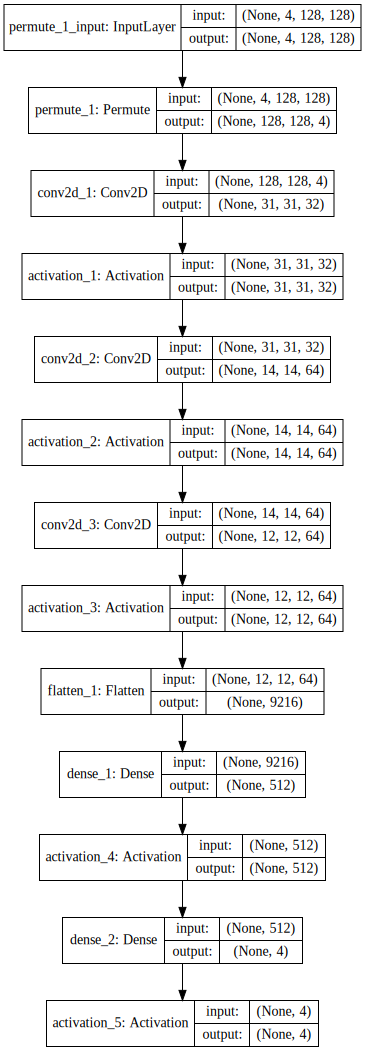

In [7]:
# モデル構造 (初回学習時)
import keras.backend as K

from keras.callbacks import ModelCheckpoint, CSVLogger
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, Permute

# Next, we build our model. We use the same model that was described by Mnih et al. (2015).
input_shape = (WINDOW_LENGTH,) + INPUT_SHAPE
model = Sequential()
if K.image_dim_ordering() == 'tf':
    # (width, height, channels)
    model.add(Permute((2, 3, 1), input_shape=input_shape))
elif K.image_dim_ordering() == 'th':
    # (channels, width, height)
    model.add(Permute((1, 2, 3), input_shape=input_shape))
else:
    raise RuntimeError('Unknown image_dim_ordering.')
model.add(Conv2D(32, (8, 8), strides=(4, 4)))
model.add(Activation('relu'))
model.add(Conv2D(64, (4, 4), strides=(2, 2)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), strides=(1, 1)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(len(ACTION_MAP)))
model.add(Activation('linear'))
#with open(MODEL_FILE, 'w') as f:
#    f.write(model.to_json())

dqn = createDQNAgent(model)

# モデル構造可視化

# 簡易版
# print(model.summary())
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
# モデル構造読み込み (学習途中再開時)
# TODO: まだうまくいかず。検討中 (再開はされるが精度が下がる)
from keras.models import load_model
import pickle

model = load_model(LAST_MODEL_FILE)

dqn = createDQNAgent(model)
dqn.load(LAST_MODEL_FILE)
dqn.step = 30000
with open(MEMORY_FILE, mode='rb') as f:
    dqn.memory = pickle.load(f)

In [7]:
# 学習スタート
hist = dqn.fit(env, nb_steps=10000000, callbacks=callbacks, visualize=False, verbose=2)

Training for 10000000 steps ...

Epoch 00001: episode_reward improved from -inf to 25.00000, saving model to dqn_MsPacman-v0_best_weights.h5f
     733/10000000: episode: 1, duration: 6.456s, episode steps: 733, steps per second: 114, episode reward: 25.000, mean reward: 0.034 [0.000, 1.000], mean action: 2.486 [1.000, 4.000], mean observation: 57.853 [0.000, 171.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --

Epoch 00002: episode_reward improved from 25.00000 to 31.00000, saving model to dqn_MsPacman-v0_best_weights.h5f
    1474/10000000: episode: 2, duration: 5.643s, episode steps: 741, steps per second: 131, episode reward: 31.000, mean reward: 0.042 [0.000, 1.000], mean action: 2.497 [1.000, 4.000], mean observation: 57.769 [0.000, 171.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --

Epoch 00003: episode_reward improved from 31.00000 to 36.00000, saving model to dqn_MsPacman-v0_best_weights.h5f
    2537/10000000: episode: 3, duration: 7.953s, epi


Epoch 00025: episode_reward did not improve
   17112/10000000: episode: 25, duration: 5.024s, episode steps: 658, steps per second: 131, episode reward: 20.000, mean reward: 0.030 [0.000, 1.000], mean action: 2.530 [1.000, 4.000], mean observation: 57.792 [0.000, 171.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --

Epoch 00026: episode_reward did not improve
   17760/10000000: episode: 26, duration: 4.861s, episode steps: 648, steps per second: 133, episode reward: 15.000, mean reward: 0.023 [0.000, 1.000], mean action: 2.488 [1.000, 4.000], mean observation: 57.900 [0.000, 171.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --

Epoch 00027: episode_reward did not improve
   18213/10000000: episode: 27, duration: 3.439s, episode steps: 453, steps per second: 132, episode reward: 20.000, mean reward: 0.044 [0.000, 1.000], mean action: 2.508 [1.000, 4.000], mean observation: 57.850 [0.000, 171.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps


Epoch 00049: episode_reward did not improve
   32897/10000000: episode: 49, duration: 125.354s, episode steps: 716, steps per second: 6, episode reward: 27.000, mean reward: 0.038 [0.000, 1.000], mean action: 2.549 [1.000, 4.000], mean observation: 57.720 [0.000, 171.000], loss: 0.119715, mean_absolute_error: 3.674201, mean_q: 4.901869, mean_eps: 0.943714

Epoch 00050: episode_reward did not improve
   33622/10000000: episode: 50, duration: 127.291s, episode steps: 725, steps per second: 6, episode reward: 23.000, mean reward: 0.032 [0.000, 1.000], mean action: 2.472 [1.000, 4.000], mean observation: 57.846 [0.000, 171.000], loss: 0.105185, mean_absolute_error: 3.663218, mean_q: 4.888638, mean_eps: 0.943066

Epoch 00051: episode_reward did not improve
   34249/10000000: episode: 51, duration: 110.414s, episode steps: 627, steps per second: 6, episode reward: 23.000, mean reward: 0.037 [0.000, 1.000], mean action: 2.536 [1.000, 4.000], mean observation: 57.834 [0.000, 171.000], loss: 0

In [ ]:
# 途中保存
import pickle

dqn.save(LAST_MODEL_FILE, overwrite=True)
with open(MEMORY_FILE, mode='wb') as f:
    pickle.dump(dqn.memory, f)

In [ ]:
dqn.load_weights(LAST_WEIGHT_FILE)

In [9]:
dqn.load_weights(BEST_WEIGHT_FILE)

In [10]:
# test trained model
dqn.test(env, nb_episodes=5, visualize=True)

Testing for 5 episodes ...
Episode 1: reward: 44.000, steps: 774
Episode 2: reward: 67.000, steps: 753
Episode 3: reward: 61.000, steps: 794
Episode 4: reward: 48.000, steps: 868
Episode 5: reward: 55.000, steps: 937


<IPython.core.display.Javascript object>


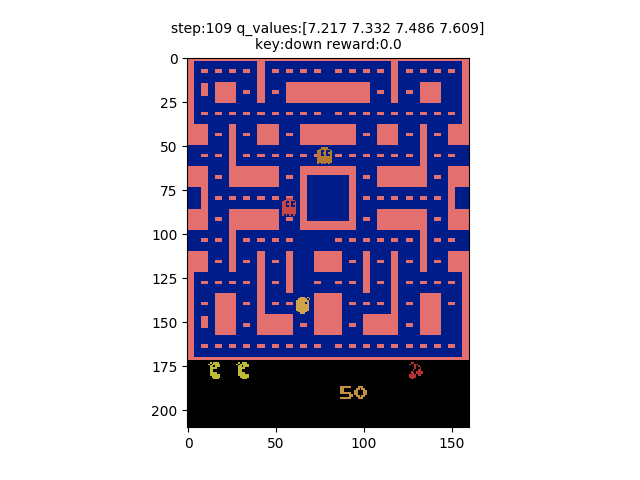

In [11]:
# create human memory and train (as human policy select)
%matplotlib notebook
import sys
import matplotlib.pyplot as plt
from copy import deepcopy

"""
指定したactionのexperienceをmemoryに格納する
"""
def append_memory(action, env, memory, processor):
    observation, reward, done, info = env.step(action)
    source_observation = deepcopy(observation)
    observation, reward, done, info = processor.process_step(source_observation, reward, done, info)
    
    if dqn.step % dqn.memory_interval == 0:
        # 加工後のobservationを渡しているため素性変更が困難になってる
        dqn.memory.append(observation, action, reward, terminal=done)
    
    return (source_observation, observation, reward, done, info)

"""
(TODO: 未使用。転移学習に使えるかも)
訓練済みモデルのexperienceをmemoryに格納していく
dqn.trainingでpolicyの有効を管理する
"""
def observe_model(dqn, env, nb_steps, action=None):
    if action is None:
        observation = deepcopy(env.reset())
    
    for i in range(nb_steps):
        if action is not None:
            _, observation, reward, done, _ = append_memory(action, env, dqn.memory, dqn.processor)
            if done:
                break
        action = dqn.forward(observation)
        

def press(event):
    action = None
    if event.key == 'up':
        action = 1
    elif event.key == 'right':
        action = 2
    elif event.key == 'left':
        action = 3
    elif event.key == 'down':
        action = 4
    
    if action is not None:
        try:
            source_observation, observation, reward, done, info = append_memory(action, env, dqn.memory, dqn.processor)
            img = Image.fromarray(source_observation)
            imgplot = plt.imshow(img)
            
            state = dqn.memory.get_recent_state(observation)
            q_values = dqn.compute_q_values(state)
            
            plt.title("step:{} q_values:{}\nkey:{} reward:{}".format(dqn.step, q_values.round(3), event.key, reward),
                     fontsize=10)
            
            dqn.step += 1
        except:
            plt.title("Unexpected error:{}".format(sys.exc_info()))     

fig, ax = plt.subplots()
fig.canvas.mpl_connect('key_press_event', press)

observation = deepcopy(env.reset())
dqn.step=0
# wait for 100 step while starting game
for i in range(90):
    env.step(0)
    dqn.step+=1
img = Image.fromarray(observation)
imgplot = plt.imshow(img)

# memoryにappendするためにも必要
dqn.training = True

plt.show()

In [ ]:
# memoryからbatchデータの作成 (大きめのバッチサイズにした方が良い)

def create_train_batch(dqn, batch_size=None):
    if batch_size is None:
        batch_size = dqn.batch_size
    experiences = dqn.memory.sample(batch_size)
    
    state0_batch = []
    reward_batch = []
    action_batch = []
    terminal1_batch = []
    state1_batch = []
    for e in experiences:
        state0_batch.append(e.state0)
        state1_batch.append(e.state1)
        reward_batch.append(e.reward)
        action_batch.append(e.action)
        terminal1_batch.append(0. if e.terminal1 else 1.)

    # convert numpy array
    state0_batch = dqn.process_state_batch(state0_batch)
    state1_batch = dqn.process_state_batch(state1_batch)
    terminal1_batch = np.array(terminal1_batch)
    reward_batch = np.array(reward_batch)
    
    # Compute Q values for mini-batch update.
    if dqn.enable_double_dqn:
        q_values = dqn.model.predict_on_batch(state1_batch)
        actions = np.argmax(q_values, axis=1)

        target_q_values = dqn.target_model.predict_on_batch(state1_batch)
        q_batch = target_q_values[range(batch_size), actions]
    else:
        target_q_values = dqn.target_model.predict_on_batch(state1_batch)
        q_batch = np.max(target_q_values, axis=1).flatten()

    targets = np.zeros((batch_size, dqn.nb_actions))
    dummy_targets = np.zeros((batch_size,))
    masks = np.zeros((batch_size, dqn.nb_actions))

    discounted_reward_batch = dqn.gamma * q_batch
    discounted_reward_batch *= terminal1_batch
    Rs = reward_batch + discounted_reward_batch
    
    for idx, (target, mask, R, action) in enumerate(zip(targets, masks, Rs, action_batch)):
        target[action] = R  # update action with estimated accumulated reward
        dummy_targets[idx] = R
        mask[action] = 1.  # enable loss for this specific action
    targets = np.array(targets).astype('float32')
    masks = np.array(masks).astype('float32')

    ins = [state0_batch] if type(dqn.model.input) is not list else state0_batch
    # return (x, y)
    return (ins + [targets, masks], [dummy_targets, targets])

(x, y) = create_train_batch(dqn, batch_size=524)

In [ ]:
# バッチデータの学習曲線可視化

from bokeh.io import output_notebook, push_notebook, show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import LinearAxis, Range1d
import os
import pandas as pd

metrics = dqn.trainable_model.test_on_batch(x, y)
df = pd.DataFrame([metrics], columns=dqn.trainable_model.metrics_names)

batch_source = ColumnDataSource(df)
fig = figure(x_axis_type="linear",
             x_axis_label="epoch",
             y_axis_label="loss",
             plot_width=800,
             plot_height=600)

fig.circle(source=source, x='index', y='loss', fill_color='white', color='blue')
fig.line(source=batch_source, x='index', y='loss', color='blue')

index = 0

output_notebook()
batch_target = show(fig, notebook_handle=True)

In [ ]:
# batch学習 (人力データから手動学習)
# epoch
for i in range(1000):
    index += 1
    metrics = dqn.trainable_model.train_on_batch(x, y)
    new_data = {}
    for key, val in zip(dqn.trainable_model.metrics_names, metrics):
        new_data[key] = [val]
    new_data['index'] = [index]
    batch_source.stream(new_data)
    push_notebook(handle=batch_target)

参考リンク
* http://matthewrocklin.com/blog/work/2017/10/16/streaming-dataframes-1
* http://elix-tech.github.io/ja/2016/06/29/dqn-ja.html
* https://qiita.com/panchovie/items/af9bac0e8ad8945bdf09
* http://tekenuko.hatenablog.com/entry/2017/07/25/005348
* http://www.procrasist.com/entry/jupyter-more-interactive
* https://github.com/tychovdo/PacmanDQN
* https://kuune.org/text/2017/07/13/market-price-prediction-with-deeplearning/

DQNの歴史
* http://www.ie110704.net/2017/10/15/pytorch%E3%81%A7%E6%B7%B1%E5%B1%A4%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%EF%BC%88dqn%E3%80%81doubledqn%EF%BC%89%E3%82%92%E5%AE%9F%E8%A3%85%E3%81%97%E3%81%A6%E3%81%BF%E3%81%9F/
* https://qiita.com/sugulu/items/3c7d6cbe600d455e853b

Q学習とActor-Criticの違い
* http://kazoo04.hatenablog.com/entry/agi-ac-14
* Q学習は離散値、Actor-Criticは連続値の行動を扱える

* Computer Science Learning Pre-training Neural Networks with Human Demonstrations for Deep Reinforcement Learning 2017 9
* https://arxiv.org/abs/1709.04083

TODO
* Policyなど精度を上げるための方法を考える
* ドメイン知識として同じ場所に留まる、移動距離が少ない場合にペナルティを入れたい
* streamzでのファイル監視はうまくいかなかった
* keras-grad-camで可視化したい
https://github.com/jacobgil/keras-grad-cam
* 一つ前のフレームと現在のフレームの各ピクセルごとに最大値を取る(点滅回避)
* パックマンと迷路の色は1色なのでそれぐらいは前処理でレイヤー分けると良さそう
* パックマンが進んだ場所を+1していき迷路問題として解かせた方が良い(ただし画像で)

Policy(Actionの選択)に学習済みモデル、ルールベースモデルを使えないか
訓練済みモデルから収束が早くなれば、BaisyanOptimizationなどでハイパーパラメータの探索ができる
収束が速くないとハイパーパラメータ探索は実質無理